# Twitter vs Stocks Change

## Data Cleaning Notebook

In [23]:
# Packages:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from urllib.request import urlopen
import json
import datetime
import numpy as np
import warnings
from textblob import TextBlob
import re
from wordcloud import WordCloud
warnings.filterwarnings('ignore')

### Tweets DF, Sentimental Analysis and Tweets Cleaning Functions

In [24]:
# Function to clean Tweet Texts:
def cleantext(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text) # Remove Mentions&amp
    text = re.sub(r"#", "", text) # Remove Hashtags Symbol
    text = re.sub(r"RT[\s]+", "", text) # Remove Retweets
    text = re.sub(r"https?:\/\/\S+", "", text) # Remove The Hyper Link
    text = re.sub(r"&", "", text) # Remove The Hyper Link
    text = re.sub(r"amp", "", text) # Remove The Hyper Link
    
    return text

In [25]:
# Function to update series for a 0 to 1 scale.
def Scalling(df_series,col_name):
    old_max = df_series.max(axis=0)
    old_min = df_series.min(axis=0)  
    OldRange = old_max - old_min  
    new_min = 0
    new_max = 1
    NewRange = (new_max - new_min)  
    df_series[col_name+"_scaled"] = (((df_series - old_min) * NewRange) / OldRange) + new_min
    return df_series[col_name+"_scaled"]

In [26]:
# Function to read and clean the raw data from API Twitter.
def Tweet_Clean(csv):

    # Pulling CSV with Twitter information. Check "api_twitter_data.ipynb" to see data extraction:
    ceo_tweets = pd.read_csv(csv)
    columns_chosed = ['created_at','full_text','id','source','favorite_count','retweet_count']
    ceo_tweets = ceo_tweets[columns_chosed]

    # Filtering Dataframe for tweets since 2019:
    ceo_tweets["created_at"] = pd.to_datetime(ceo_tweets["created_at"]).dt.date
    ceo_tweets["created_at"] = pd.to_datetime(ceo_tweets["created_at"])
    ceo_tweets = ceo_tweets[ceo_tweets["created_at"]>='2019-01-01']

    # Clean The Tweets Text:
    ceo_tweets['full_text'] = ceo_tweets['full_text'].apply(cleantext)

    # Check for Tweets made during weekends:
    ceo_tweets["Day of Week"] = ceo_tweets['created_at'].dt.dayofweek
    ceo_tweets['orig_date'] = ceo_tweets['created_at']

    # Moving Tweets made during weekend to Monday (since these should impact Stock price when the market opens):
    for i in range(ceo_tweets.shape[0]):
        if ceo_tweets['Day of Week'].loc[i] == 5:
            ceo_tweets['created_at'].loc[i] = ceo_tweets['created_at'].loc[i]+ datetime.timedelta(days=2)
        if ceo_tweets['Day of Week'].loc[i] == 6:
            ceo_tweets['created_at'].loc[i] = ceo_tweets['created_at'].loc[i]+ datetime.timedelta(days=1)

    # Get The Subjectivity of each Tweet.
    def sentiment_analysis(ds):
        sentiment = TextBlob(ds['full_text']).sentiment
        return pd.Series([sentiment.subjectivity, sentiment.polarity])

    # Adding Subjectivity & Polarity
    ceo_tweets[["subjectivity", "polarity"]] = ceo_tweets.apply(sentiment_analysis, axis=1)

    # Aggregating Tweets by Date:
    ceo_tweets = (    
        ceo_tweets.groupby(["created_at"])
        .agg(
            Tweets=("full_text", "sum"),
            Agg_count=("full_text", "count"),
            Agg_retweet=("retweet_count", "sum"),
            Agg_favorite=("favorite_count", "sum"),
            Subjectivity_mean=("subjectivity", "mean"),
            Polarity_mean=("polarity", "mean"),
        )
        .reset_index()
    )
    ceo_tweets = ceo_tweets.rename(columns={"created_at":'Date'})

    #Scaling Polarity from -1 to 1 scale to 0 to 1 scale:    
    ceo_tweets["Polarity_scaled"] = Scalling(ceo_tweets["Polarity_mean"],"Polarity")
    
    # Calculating Delta for Polarity
    ceo_tweets["Polarity_delta"] = ceo_tweets["Polarity_scaled"]-ceo_tweets["Polarity_scaled"].shift()
    
    #Scaling Favorite_count and Retweet count
    ceo_tweets["Favorite_scaled"] = Scalling(ceo_tweets["Agg_favorite"],"Favorite")
    ceo_tweets["Retweet_scaled"] = Scalling(ceo_tweets["Agg_retweet"],"Retweet")
    
    return ceo_tweets

### Stock Data Cleaning Function

In [27]:
def Stock_Clean(stock):

    # Getting Data Stock prices. Source: Yahoo Finance.
    stock = pd.read_csv(stock)
    stock_df = stock[['Date','Close']]

    # Scaling Stock Price to 0 to 1:
    stock_df["Price_scaled"] = Scalling(stock_df["Close"],"Price")
    
    # Calculating Stock Price Delta:
    stock_df["Price_delta"] = stock_df["Price_scaled"]-stock_df["Price_scaled"].shift()

    stock_df = stock_df.rename(columns={"Close":'Price'})
    stock_df["Date"] = pd.to_datetime(stock_df["Date"]).dt.date
    stock_df["Date"] = pd.to_datetime(stock_df["Date"])
    
    return stock_df

### Function to Merge Stocks and Tweets DFs:

In [28]:
def Merging_dfs(stock_df,ceo_tweets):

    df_stock_tweets = stock_df.merge(ceo_tweets, how='left', on='Date')

    colnan = ['Agg_count','Agg_retweet','Agg_favorite','Subjectivity_mean','Polarity_mean','Polarity_scaled','Polarity_delta',"Favorite_scaled","Retweet_scaled"]
    
    for col in colnan:
        df_stock_tweets[col] = df_stock_tweets[col].fillna(0)

    df_stock_tweets['Tweets'] = df_stock_tweets['Tweets'].fillna('')
    
    return df_stock_tweets

## Word Cloud Function:

In [29]:
def Word_Cloud(df_stock_tweets,ceo_name):
    allwords = " ".join([twts for twts in df_stock_tweets['Tweets']])
    wordCloud = WordCloud(width = 1000, height = 1000, random_state = 21, max_font_size = 119).generate(allwords)
    plt.figure(figsize=(20, 20), dpi=80)
    plt.imshow(wordCloud, interpolation = "bilinear")
    plt.axis("off")
    plt.savefig('../images/'+ceo_name+'.png');

## Applying the functions:

,Date,Price,Price_scaled,Price_delta,Tweets,Agg_count,Agg_retweet,Agg_favorite,Subjectivity_mean,Polarity_mean,Polarity_scaled,Polarity_delta,Favorite_scaled,Retweet_scaled
0,2019-02-06,34.160000,0.218587,NaN,Huh I believe so Thank youI love . It’s com...,75.0,1928.0,15265.0,0.237146,0.106136,0.404091,0.000000,0.019773,0.000833
1,2019-02-07,30.799999,0.158188,-0.060399,! G N I Z a M A You’re amazing! Progress I do...,12.0,1570.0,3237.0,0.075000,0.062500,0.375000,-0.029091,0.004193,0.000678
2,2019-02-08,30.010000,0.143987,-0.014201,Live tweeting Live tweets. Anything a tweet ...,25.0,26207.0,3499.0,0.260192,0.066232,0.377488,0.002488,0.004532,0.011323
3,2019-02-11,30.230000,0.147942,0.003955,True Thanks! Maybe an error Good thing we ha...,27.0,4891.0,6078.0,0.242670,0.191647,0.461098,0.083610,0.007873,0.002113
4,2019-02-12,30.389999,0.150818,0.002876,"Go eat! Thanks, Kara karajack I don’t think y...",60.0,1083.0,9433.0,0.397864,0.131205,0.420803,-0.040295,0.012219,0.000468


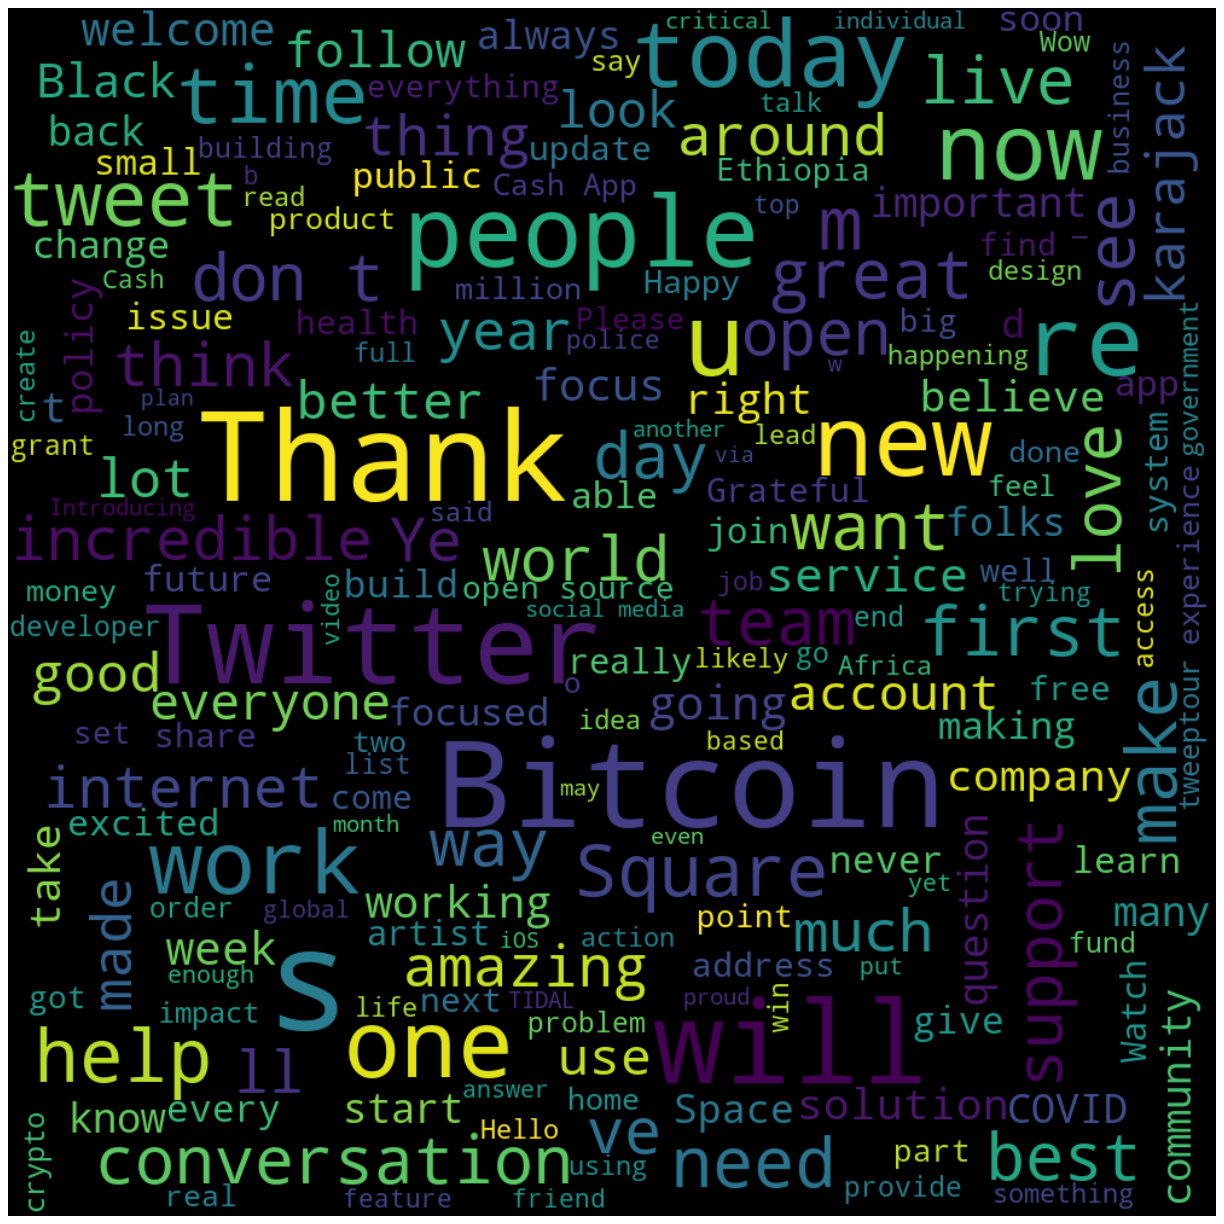

In [31]:
ceo_name = 'dorsey'
stock_code = 'TWTR'

ceo_tweets = Tweet_Clean("../data/raw/"+ceo_name+".csv")
stock_df = Stock_Clean("../data/raw/"+stock_code+".csv")
df_stock_tweets = Merging_dfs(stock_df,ceo_tweets)

df_stock_tweets.to_csv('../data/processed/'+ceo_name+'_cleaned.csv', index=False)
Word_Cloud(df_stock_tweets,ceo_name);
df_stock_tweets.head()

## Preliminary Plots

In [ ]:
fig = go.Figure()
_ = fig.add_trace(go.Scatter(
    x= df_stock_tweets['Polarity_delta'],
    y= df_stock_tweets['Price_delta'],
    mode="markers",
    marker={"size": df_stock_tweets['Agg_favorite'], "sizemode": "area",
                                    "sizeref": 2*max(df_stock_tweets['Agg_favorite']/1000)},
    hovertemplate= "Number of Tweets per Day: %{x:.1f}<br>" +
    "Stock Price Change: %{y:.1f}<br>" +
    "Number of Likes: %{marker.size:,}" +
    "<extra></extra>"
))
fig.update_layout(
    plot_bgcolor="white",
    yaxis={"title": {"text": "Stock Price Delta Change", "font": {"size": 16}}},
    xaxis={"title": {"text": "Tweets Polarity Delta Change", "font": {"size": 16}}},
    # hovermode="x",
    title={'text': "CEO's Tweets Polarity vs Stock Price -  Delta Change", "font": {"size": 16}}
)
fig.show()

In [ ]:
fig = go.Figure()
_ = fig.add_trace(go.Scatter(
    x= df_stock_tweets['Agg_favorite'],
    y= df_stock_tweets['Price_delta'],
    mode="markers",
    marker={"size": df_stock_tweets['Agg_count'], "sizemode": "area",
                                    "sizeref": 2*max(df_stock_tweets['Agg_count']/1000)},
    hovertemplate= "Number of Tweets Liked per Day: %{x:.1f}<br>" +
    "Stock Price Change: %{y:.1f}<br>" +
    "Number of Tweets: %{marker.size:,}" +
    "<extra></extra>"
))
fig.update_layout(
    plot_bgcolor="white",
    yaxis={"title": {"text": "Stock Price Delta Change", "font": {"size": 16}}},
    xaxis={"title": {"text": "# of Tweets Liked per Day", "font": {"size": 16}}},
    # hovermode="x",
    title={'text': "CEO's # Tweets Liked vs Stock Price Delta Change", "font": {"size": 16}}
)
fig.show()

In [ ]:
fig = go.Figure()
_ = fig.add_trace(go.Scatter(
    x= df_stock_tweets["Agg_count"],
    y= df_stock_tweets['Price_delta'],
    mode="markers",
    marker={"size": df_stock_tweets['Agg_favorite'], "sizemode": "area",
                                    "sizeref": 2*max(df_stock_tweets['Agg_favorite']/1000)},
    hovertemplate= "Polarity of Tweets: %{x:.1f}<br>" +
    "Stock Price Change: %{y:.1f}<br>" +
    "Number of Likes: %{marker.size:,}" +
    "<extra></extra>"
))
fig.update_layout(
    plot_bgcolor="white",
    # hovermode="x",
    xaxis={"title": {"text": "Number of Tweets", "font": {"size": 16}}},
    yaxis={"title": {"text": "Stock Price Delta Change", "font": {"size": 16}}},
    title={'text': "CEO's Number of Tweets vs Stock Price Delta Change", "font": {"size": 16}}
)
fig.show()